In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
pd.set_option('display.precision', 3)

# Data Visualisation Libraries
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('darkgrid')

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import learning_curve

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

ModuleNotFoundError: No module named 'xgboost'

## Parameters and variables 

In [41]:
random_state = 42
scoring_metric = 'recall'

In [42]:
Y_train = pd.read_csv('../Dataset/Y_train.csv')
X_train = pd.read_csv('../Dataset/X_train.csv')

Y_test = pd.read_csv('../Dataset/Y_test.csv')
X_test = pd.read_csv('../Dataset/X_test.csv')

In [58]:
font_size = 20
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

colors = ['#00A5E0', '#DD403A']
colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

random_state = 42
scoring_metric = 'recall'
comparison_dict, comparison_test_dict = {}, {}

# Functions

# plot_conf_mx()

In [43]:
def plot_conf_mx(cm, ax):
    '''Plot a confusion matrix in the specified axes object.'''
    sns.heatmap(data=cm,
                annot=True,
                cmap='Blues',
                annot_kws={'fontsize': 30},
                ax=ax)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Retained', 'Churned']);

## plot_learning_curve()

In [44]:
def plot_learning_curve(estimator,
                        X,
                        y,
                        ax,
                        cv=None,
                        train_sizes=np.linspace(0.1, 1.0, 5)):
    '''Plot the learning curves for an estimator in the specified axes object.'''
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,
                    color='dodgerblue')
    ax.fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color='darkorange')

    ax.plot(train_sizes,
            train_scores_mean,
            color='dodgerblue',
            marker='o',
            linestyle='-',
            label='Training Score')
    ax.plot(train_sizes,
            test_scores_mean,
            color='darkorange',
            marker='o',
            linestyle='-',
            label='Cross-validation Score')
    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.legend(loc='best', fontsize=14);

## clf_performance()

In [45]:
def clf_performance(classifier, classifier_name, classifier_name_abv):
    '''Display the overall performance of a classifier with this template.'''
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format(scoring_metric) + str(np.round(classifier.best_score_, 3)))
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items():
        print('      {}: {}'.format(key, value))

    y_pred_pp = cross_val_predict(estimator=classifier.best_estimator_,
                                  X=X_train,
                                  y=Y_train,
                                  cv=5,
                                  method='predict_proba')[:, 1]
    y_pred = y_pred_pp.round()

    cm = confusion_matrix(Y_train, y_pred, normalize='true')

    fpr, tpr, _ = roc_curve(Y_train, y_pred_pp)
    comparison_dict[classifier_name_abv] = [
        accuracy_score(Y_train, y_pred),
        precision_score(Y_train, y_pred),
        recall_score(Y_train, y_pred),
        roc_auc_score(Y_train, y_pred_pp), fpr, tpr
    ]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    plot_conf_mx(cm, ax1)
    plot_learning_curve(classifier.best_estimator_, X_train, y_train, ax2)

    plt.tight_layout();

## plot_feature_imp()

In [46]:
def plot_feature_imp(classifier, classifier_name, color, ax):
    '''Plot the importance of features for a classifier as a barplot.'''
    importances = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(classifier.best_estimator_.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')

    importances.plot.barh(color=color,
                          edgecolor='firebrick',
                          legend=False,
                          ax=ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance');

## Test_func()

In [47]:
def test_func(classifier, classifier_name, ax):
    '''Assess the performance on the test set and plot the confusion matrix.'''
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(Y_test, y_pred, normalize='true')

    comparison_test_dict[classifier_name] = [accuracy_score(Y_test, y_pred),
                                             precision_score(Y_test, y_pred),
                                             recall_score(Y_test, y_pred)]

    sns.heatmap(cm,
                annot=True,
                annot_kws={'fontsize': 24},
                cmap='Blues',
                ax=ax)
    ax.set_title(classifier_name)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.2, 1.4])
    ax.set_yticklabels(['Retained', 'Churned']);
    

Models

In [48]:
clf_list = [('Gaussian Naive Bayes', GaussianNB()),
            ('Logistic Regression', LogisticRegression(random_state=random_state))]

cv_base_mean, cv_std = [], []
for clf in clf_list:

    cv = cross_val_score(estimator=clf[1],
                         X=X_train,
                         y=Y_train,
                         scoring=scoring_metric,
                         cv=5,
                         n_jobs=-1)

    cv_base_mean.append(cv.mean())
    cv_std.append(cv.std())

print('Baseline Models (Recall):')

for i in range(len(clf_list)):
    print('   {}: {}'.format(clf_list[i][0], np.round(cv_base_mean[i], 2)))

Baseline Models (Recall):
   Gaussian Naive Bayes: 0.7
   Logistic Regression: 0.69


# Model Tuning


The six classifiers which is selected in this project:
1. Logistic Regression
2. Support Vector Classifier
3. Random Foét Classifier
4. Gradient Boosting Classifier
5. Xtrêm Gradient Boosting Classifier
6. Light Gradient Boosting Machine

Logistic Regression

In [53]:
lr = LogisticRegression(random_state=random_state)

param_grid = {
    'max_iter': [100],
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

lr_clf = GridSearchCV(estimator=lr,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_lr_clf = lr_clf.fit(X_train, Y_train)
clf_performance(best_lr_clf, 'Logistic Regression', 'LR')


 Logistic Regression
-------------------------------
   Best Score (recall): 0.73
   Best Parameters: 
      C: 0.001
      max_iter: 100
      penalty: l1
      solver: liblinear


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\s

IndexError: index 1 is out of bounds for axis 1 with size 1

## Support Vector Classifier

In [54]:
svc = SVC(probability=True, random_state=random_state)

param_grid = tuned_parameters = [{'kernel': ['rbf'],
                                  'gamma': ['scale', 'auto'],
                                  'C': [.1, 1, 2]},
                                 {'kernel': ['linear'],
                                  'C': [.1, 1, 10]}
                                ]

svc_clf = GridSearchCV(estimator=svc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_svc_clf = svc_clf.fit(X_train, Y_train)
clf_performance(best_svc_clf, 'Support Vector Classifier', 'SVC')

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



 Support Vector Classifier
-------------------------------
   Best Score (recall): 0.78
   Best Parameters: 
      C: 2
      gamma: scale
      kernel: rbf


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:1166: RuntimeWarning: Number of classes in training fold (2) does not match total number of classes (1). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(


IndexError: index 1 is out of bounds for axis 1 with size 1

## Random Forest

In [56]:
rf = RandomForestClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [100],
    'criterion': ['entropy', 'gini'],
    'bootstrap': [True, False],
    'max_depth': [6],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 3, 5]
}

rf_clf = GridSearchCV(estimator=rf,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_rf_clf = rf_clf.fit(X_train, Y_train)
clf_performance(best_rf_clf, 'Random Forest', 'RF')

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
180 fits failed out of a total of 360.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py",


 Random Forest
-------------------------------
   Best Score (recall): 0.77
   Best Parameters: 
      bootstrap: True
      criterion: gini
      max_depth: 6
      max_features: sqrt
      min_samples_leaf: 5
      min_samples_split: 2
      n_estimators: 100


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:1166: RuntimeWarning: Number of classes in training fold (2) does not match total number of classes (1). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(


IndexError: index 1 is out of bounds for axis 1 with size 1

## Gradient Boosting Classifier

In [57]:
gbc = GradientBoostingClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [600],
    'subsample': [0.66, 0.75],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3],  # default=3
    'min_samples_split': [5, 7],
    'min_samples_leaf': [3, 5],
    'max_features': ['auto', 'log2', None],
    'n_iter_no_change': [20],
    'validation_fraction': [0.2],
    'tol': [0.01]
}

gbc_clf = GridSearchCV(estimator=gbc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_gbc_clf = gbc_clf.fit(X_train, Y_train)
clf_performance(best_gbc_clf, 'Gradient Boosting Classifier', 'GBC')

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
80 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", 


 Gradient Boosting Classifier
-------------------------------
   Best Score (recall): 0.755
   Best Parameters: 
      learning_rate: 0.01
      max_depth: 3
      max_features: None
      min_samples_leaf: 3
      min_samples_split: 5
      n_estimators: 600
      n_iter_no_change: 20
      subsample: 0.66
      tol: 0.01
      validation_fraction: 0.2


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_gb.py:424: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:1166: RuntimeWarning: Number of classes in training fold (2) does not match total number of classes (1). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(


IndexError: index 1 is out of bounds for axis 1 with size 1

In [59]:
best_gbc_clf.best_estimator_.n_estimators_

284

## XGBoost Classifier

In [60]:
xgb = XGBClassifier(random_state=random_state)

param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3, 4],  # default=6
    'reg_alpha': [1, 2],
    'reg_lambda': [1, 2],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.50, 0.75],
    'gamma': [0.1, 0.5, 1],
    'min_child_weight': [1]
}

xgb_clf = GridSearchCV(estimator=xgb,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_xgb_clf = xgb_clf.fit(X_train, Y_train)
clf_performance(best_xgb_clf, 'XGBoost Classifier', 'XGB')


 XGBoost Classifier
-------------------------------
   Best Score (recall): 0.785
   Best Parameters: 
      colsample_bytree: 0.5
      gamma: 1
      learning_rate: 0.001
      max_depth: 4
      min_child_weight: 1
      n_estimators: 50
      reg_alpha: 1
      reg_lambda: 1
      subsample: 0.75


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:1166: RuntimeWarning: Number of classes in training fold (2) does not match total number of classes (1). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(


IndexError: index 1 is out of bounds for axis 1 with size 1

## LGBMClassifier

In [61]:
lgbmc = LGBMClassifier(random_state=random_state)

param_grid = {
    'max_depth': [5],
    'num_leaves': [5, 10],
    'learning_rate': [0.001, 0.01],
    'n_estimators': [200],
    'feature_fraction': [0.5],
    'min_child_samples': [5, 10],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5]
}

lgbmc_clf = GridSearchCV(estimator=lgbmc,
                         param_grid=param_grid,
                         scoring=scoring_metric,
                         cv=5,
                         verbose=False,
                         n_jobs=-1)

best_lgbmc_clf = lgbmc_clf.fit(X_train, Y_train)
clf_performance(best_lgbmc_clf, 'LGBMClassifier', 'LGBMC')

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Info] Number of positive: 6356, number of negative: 6356
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 776
[LightGBM] [Info] Number of data points in the train set: 12712, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

 LGBMClassifier
-------------------------------
   Best Score (recall): 0.779
   Best Parameters: 
      feature_fraction: 0.5
      learning_rate: 0.01
      max_depth: 5
      min_child_samples: 10
      n_estimators: 200
      num_leaves: 10
    

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:1166: RuntimeWarning: Number of classes in training fold (2) does not match total number of classes (1). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(


IndexError: index 1 is out of bounds for axis 1 with size 1

## Ensemble Learning

In [62]:
estimators = [('LR', best_lr_clf.best_estimator_),
              ('SCV', best_svc_clf.best_estimator_),
              ('RF', best_rf_clf.best_estimator_),
              ('GBC', best_gbc_clf.best_estimator_),
              ('XGB', best_xgb_clf.best_estimator_),
              ('LGBMC', best_lgbmc_clf.best_estimator_)]

tuned_voting_soft = VotingClassifier(estimators=estimators[1:],
                                     voting='soft',
                                     n_jobs=-1)
estimators.append(('SoftV', tuned_voting_soft))

y_pred_pp = cross_val_predict(tuned_voting_soft,
                              X_train,
                              Y_train,
                              cv=5,
                              method='predict_proba')[:, 1]
y_pred = y_pred_pp.round()

cm = confusion_matrix(Y_train, y_pred, normalize='true')
fpr, tpr, _ = roc_curve(Y_train, y_pred_pp)
comparison_dict['SVot'] = [
    accuracy_score(Y_train, y_pred),
    precision_score(Y_train, y_pred),
    recall_score(Y_train, y_pred),
    roc_auc_score(Y_train, y_pred_pp), fpr, tpr
]

print('Soft Voting\n-----------------')
print('  Recall: ', np.round(recall_score(Y_train, y_pred), 3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

plot_conf_mx(cm, ax1)
plot_learning_curve(tuned_voting_soft, X_train, Y_train, ax2)

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:1166: RuntimeWarning: Number of classes in training fold (2) does not match total number of classes (1). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(


IndexError: index 1 is out of bounds for axis 1 with size 1

# Result

# Learning Curves

# Feature Importance

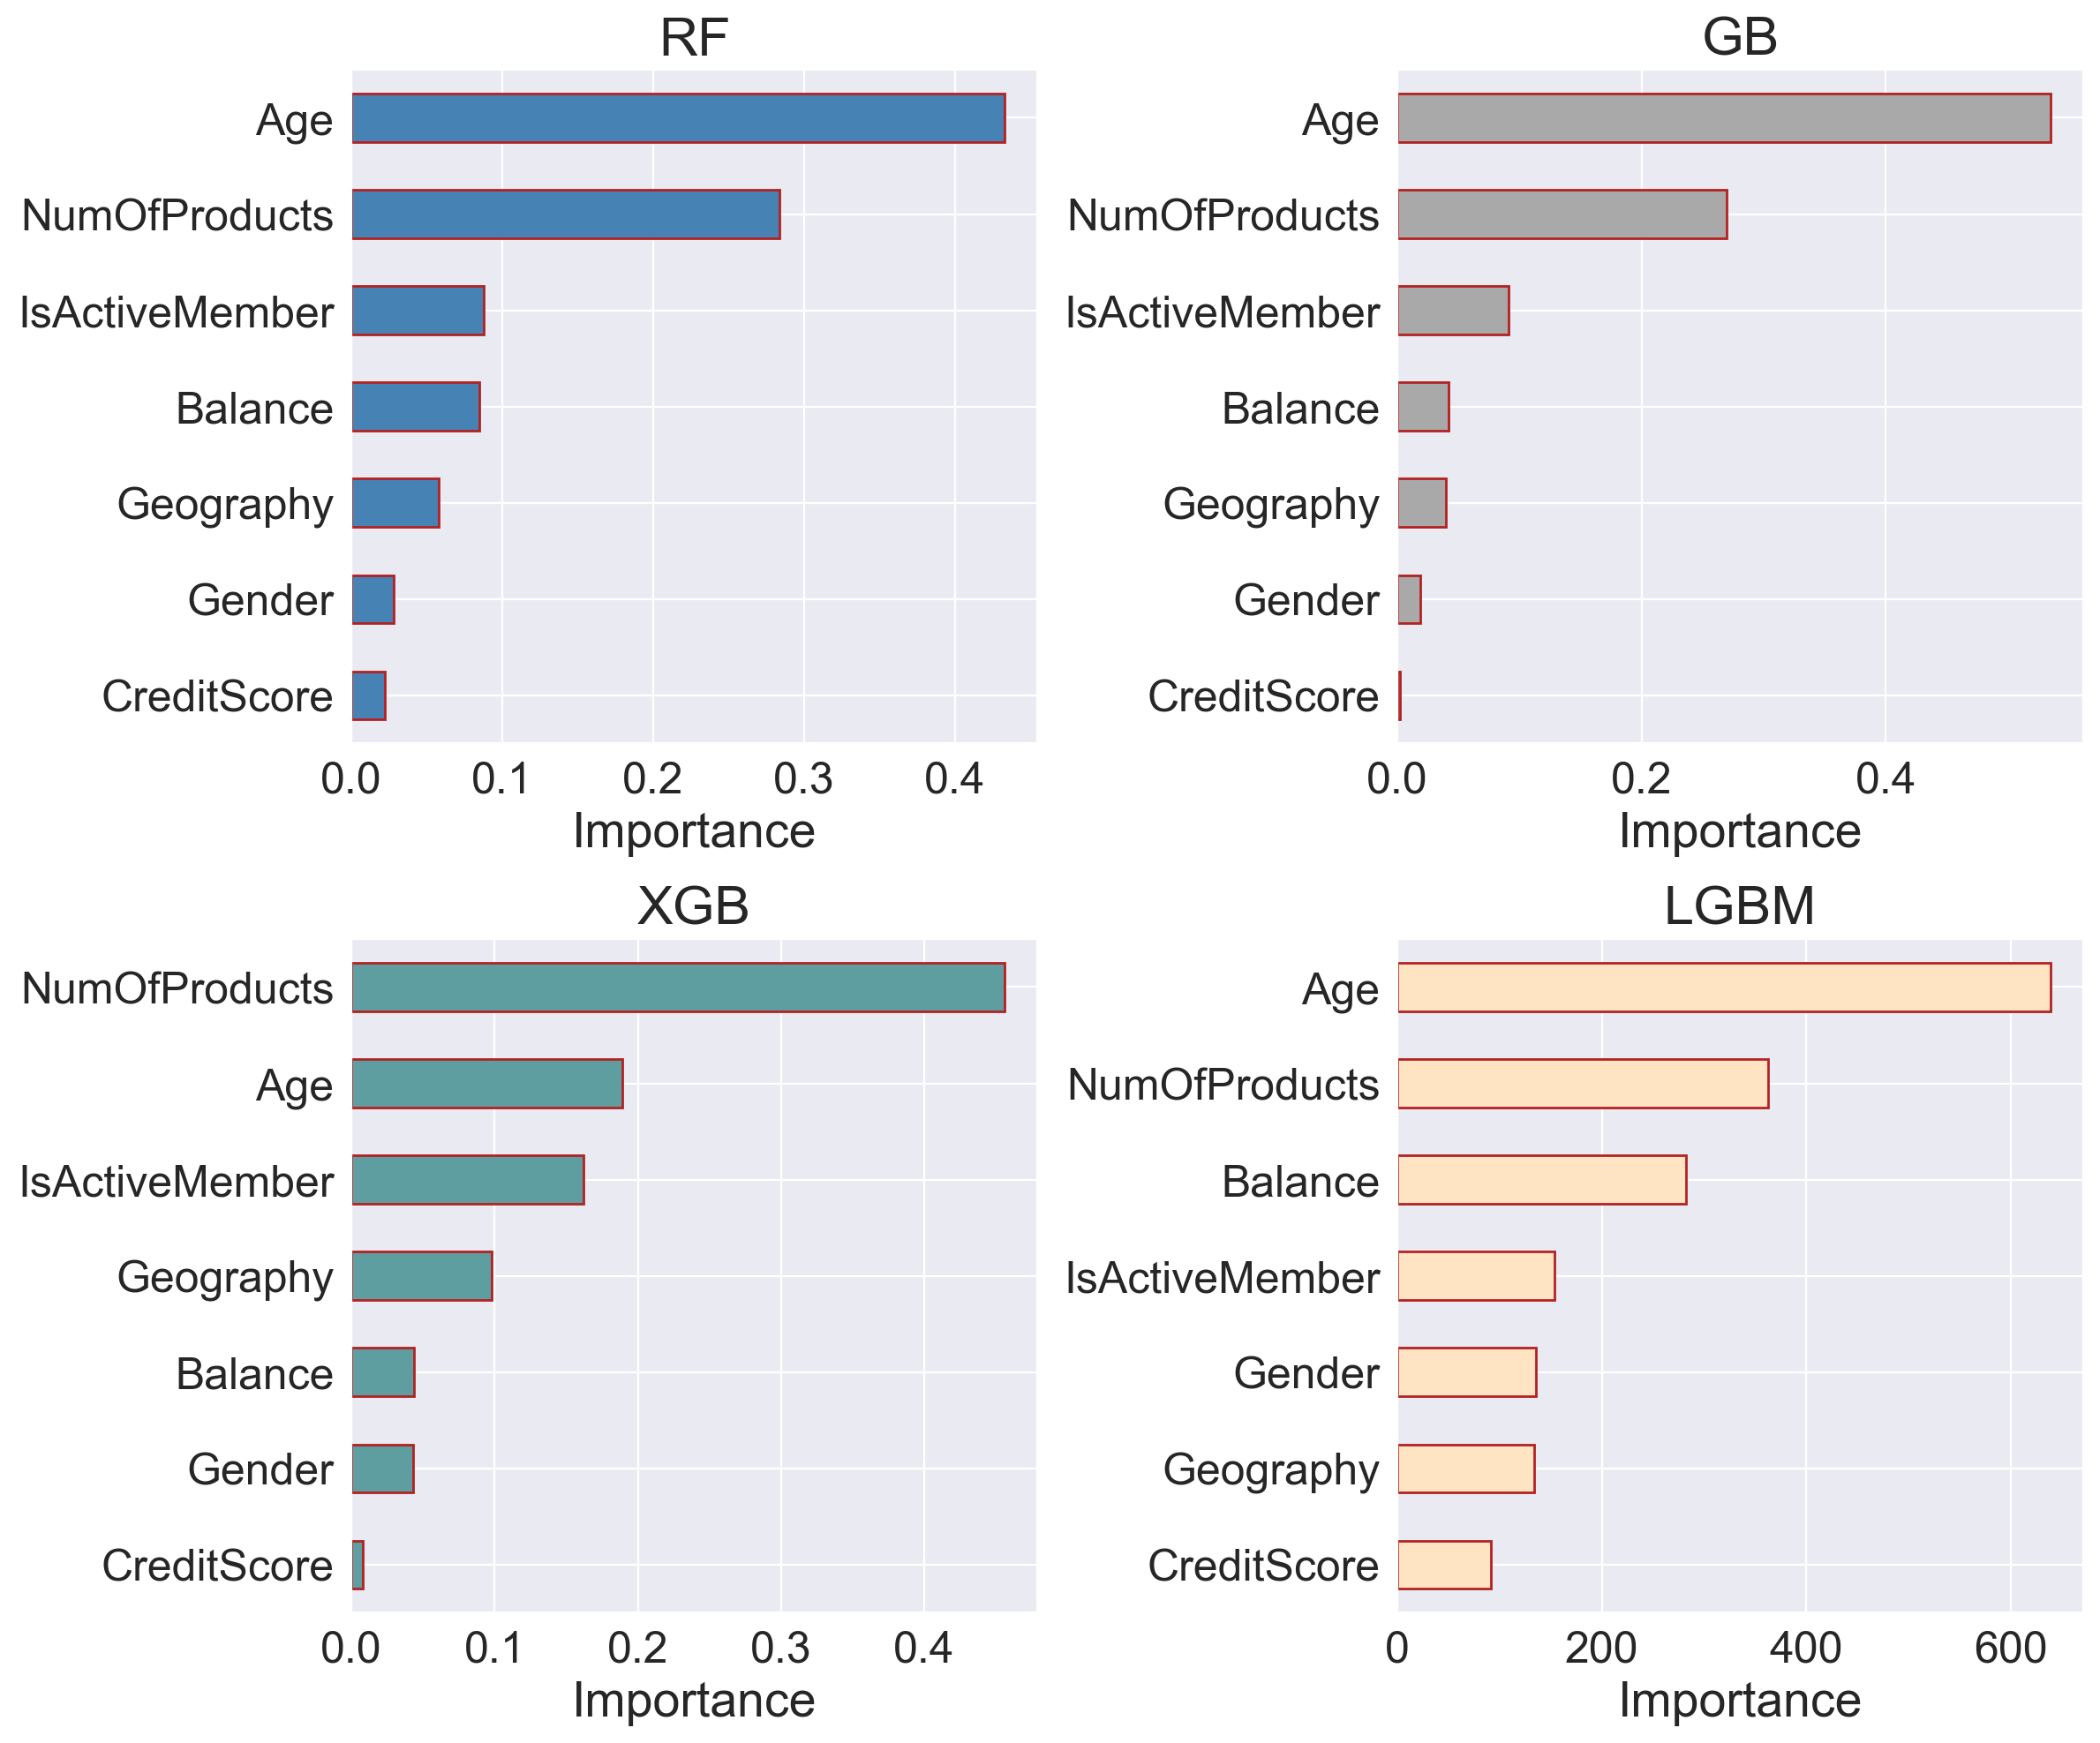

In [63]:
colors_fi = ['steelblue', 'darkgray', 'cadetblue', 'bisque']

fig = plt.subplots(2, 2, figsize=(12, 10))

for i, (name, clf) in enumerate(zip(['RF', 'GB', 'XGB', 'LGBM'],
                                    [best_rf_clf, best_gbc_clf, best_xgb_clf, best_lgbmc_clf])):

    ax = plt.subplot(2, 2, i + 1)
    plot_feature_imp(clf, name, colors_fi[i], ax)
    plt.ylabel('')

plt.tight_layout();

# Performance Comparison

In [64]:
comparison_matrix = {}
for key, value in comparison_dict.items():
    comparison_matrix[str(key)] = value[0:4]

comparison_df = pd.DataFrame(comparison_matrix,
                             index=['Accuracy', 'Precision', 'Recall', 'AUC']).T
comparison_df.style.highlight_max(color='indianred', axis=0)

,Accuracy,Precision,Recall,AUC


IndexError: index 0 is out of bounds for axis 0 with size 0

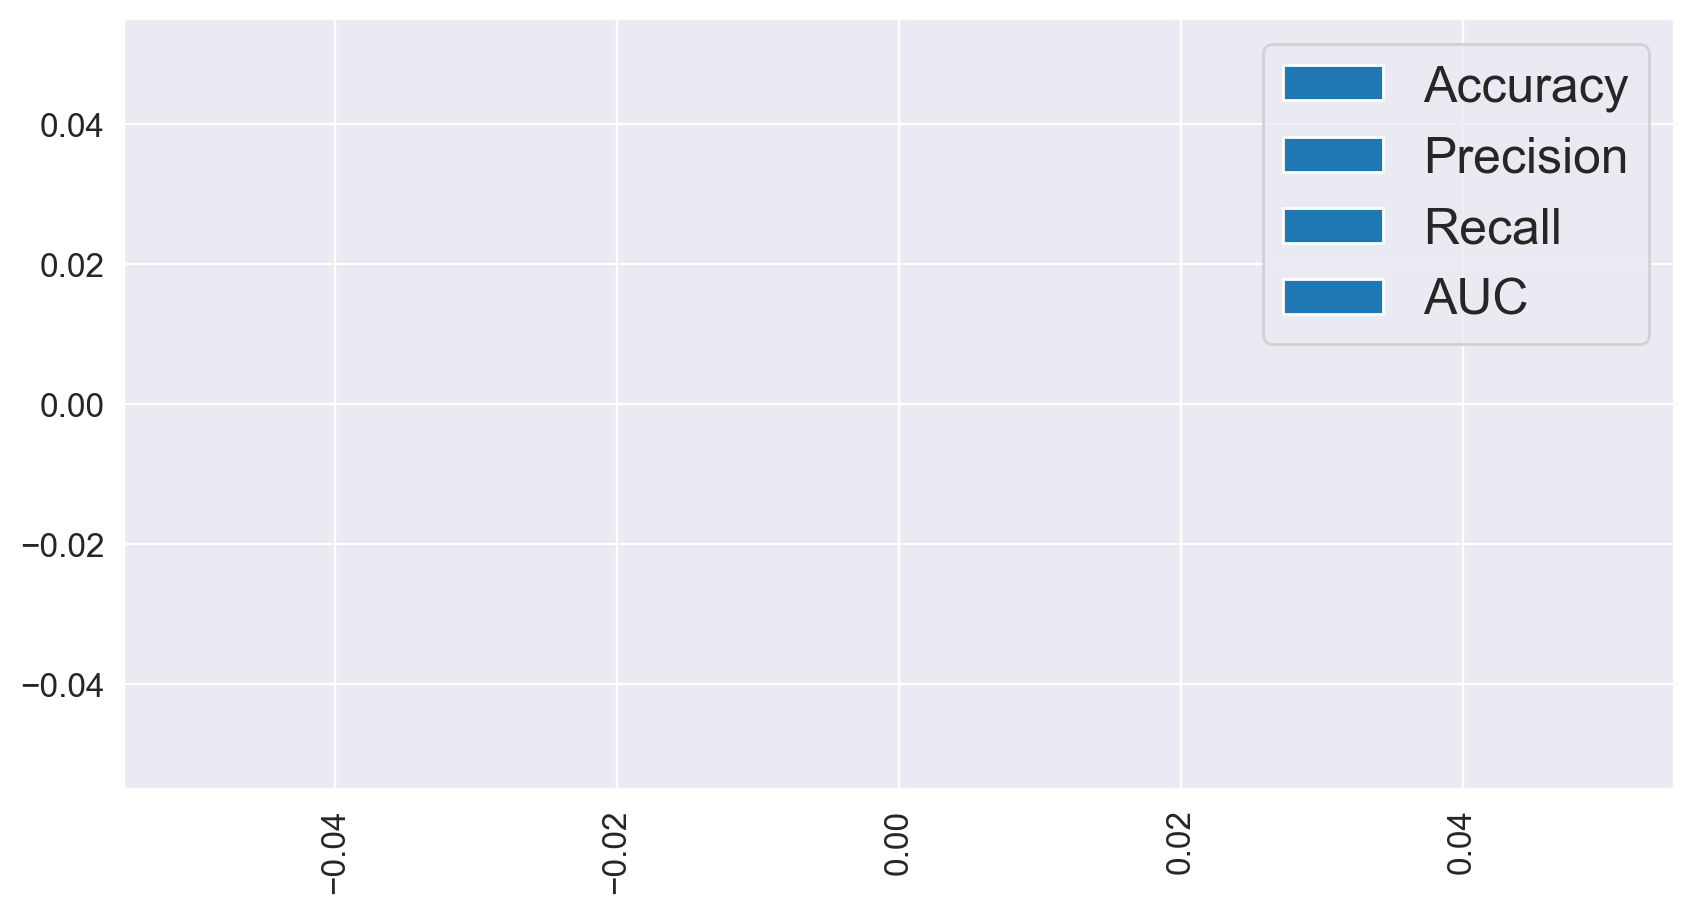

In [65]:
comparison_df.plot(kind='bar',
                   figsize=(10, 5),
                   fontsize=12,
                   color=['#5081DE', '#A7AABD', '#D85870', '#424656'])

plt.legend(loc='upper center',
           fontsize=font_size - 6,
           ncol=len(comparison_df.columns),
           bbox_to_anchor=(0.5, 1.12))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='red', linestyle='--')
plt.text(x=-0.5, y=0.73, s='0.70', size=font_size + 2, color='red');

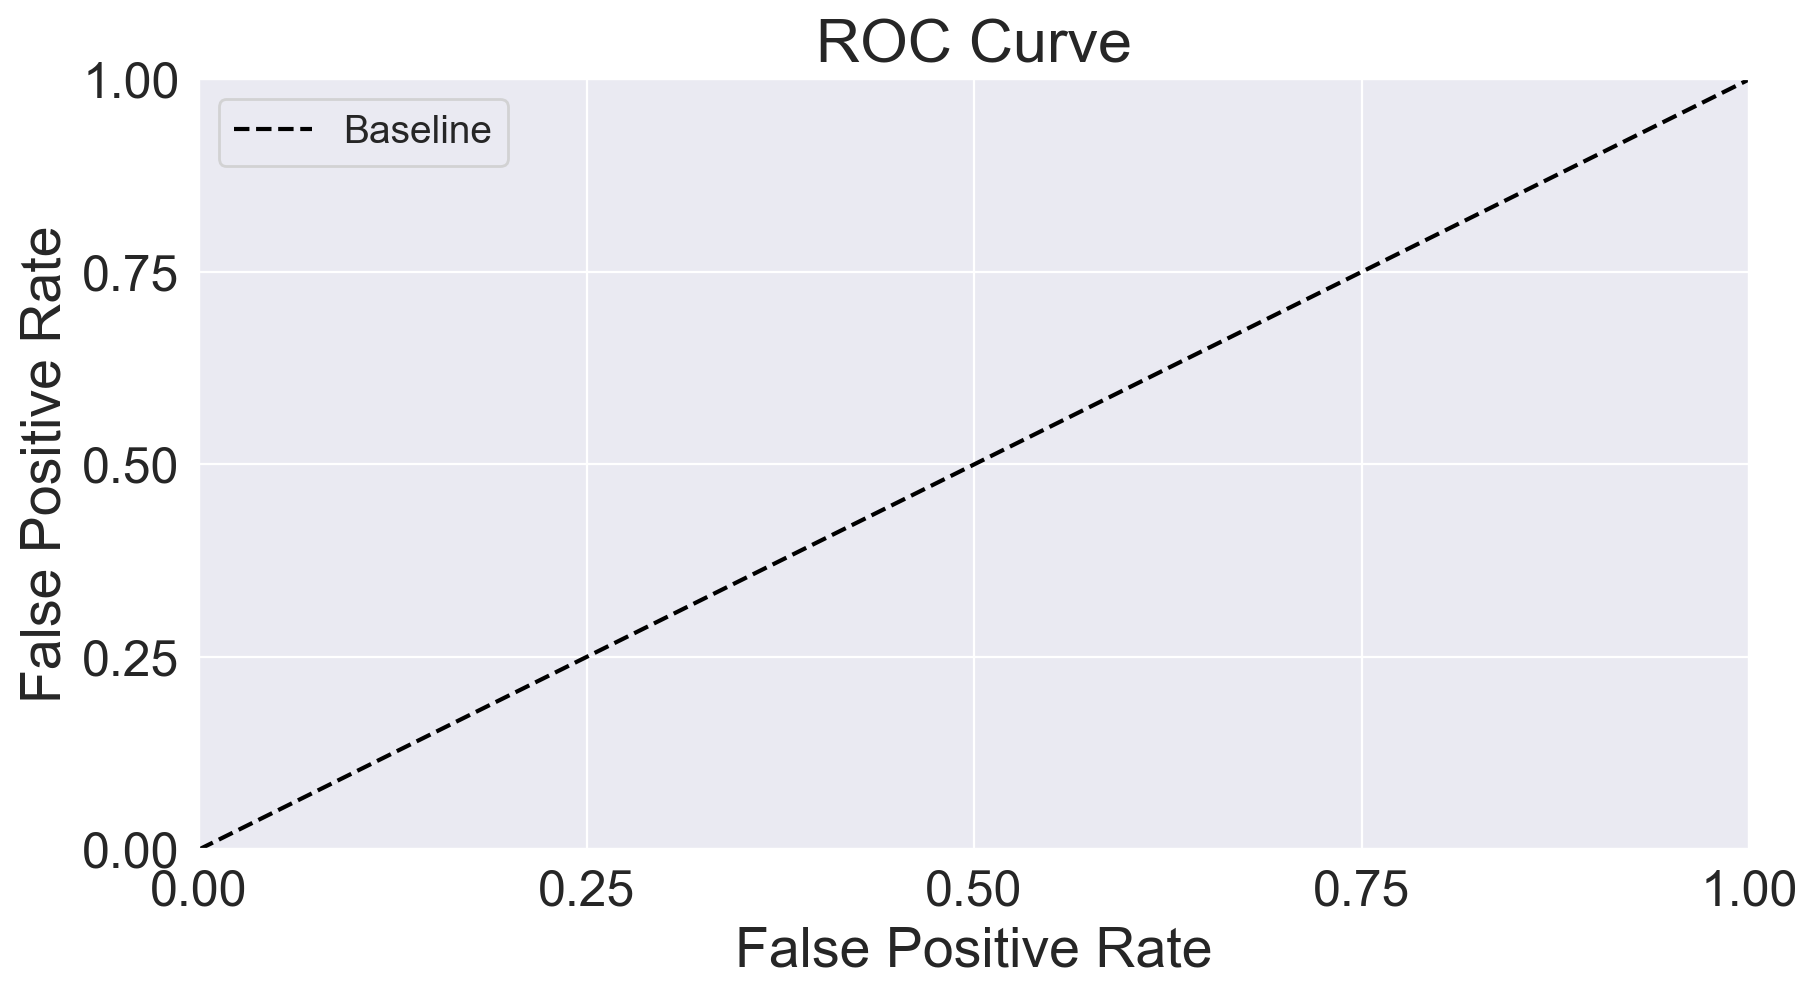

In [66]:
fig, ax = plt.subplots(figsize=(10, 5))

for index, key in enumerate(comparison_dict.keys()):
    auc, fpr, tpr = comparison_dict[key][3], comparison_dict[key][4], comparison_dict[key][5]
    ax.plot(fpr,
            tpr,
            color=colors_comp[index],
            label='{}: {}'.format(key, np.round(auc, 3)))

ax.plot([0, 1], [0, 1], 'k--', label='Baseline')

ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_ylabel('False Positive Rate')
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.autoscale(axis='both', tight=True)
ax.legend(fontsize=14);

In [67]:
print('Soft Voting:')

y_pred = cross_val_predict(tuned_voting_soft,
                           X_train,
                           Y_train,
                           cv=5,
                           method='predict_proba')

fig, ax = plt.subplots(figsize=(10, 5))

skplt.metrics.plot_cumulative_gain(Y_train, y_pred, ax=ax)

ax.plot([0.5, 0.5], [0, 0.8], color='firebrick')
ax.plot([0.0, 0.5], [0.8, 0.8], color='firebrick')

ax.set_title('Cumulative Gains Curve', size=font_size)
ax.set_xlabel('Percentage of Sample', size=font_size)
ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=font_size - 2)

ax.set_ylabel('Gain', size=font_size)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], fontsize=font_size - 2)

ax.text(0.15, 0.81, '80%', size=font_size, color='firebrick')
ax.legend(fontsize=14)

Soft Voting:


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:1166: RuntimeWarning: Number of classes in training fold (2) does not match total number of classes (1). Results may not be appropriate for your use case. To fix this, use a cross-validation technique resulting in properly stratified folds
  warnings.warn(


IndexError: index 1 is out of bounds for axis 1 with size 1

# Evaluating the Test Set

In [ ]:
tuned_voting_soft.fit(X_train, Y_train)

fig, ax = plt.subplots(7, 1, figsize=(5, 30))

for i, (name, clf) in enumerate(zip(['LR', 'SVC', 'RF', 'GB', 'XGB', 'LGBM', 'SVot'], 
                                    [best_lr_clf.best_estimator_, best_svc_clf.best_estimator_, best_rf_clf.best_estimator_, best_gbc_clf.best_estimator_, best_xgb_clf.best_estimator_, best_lgbmc_clf.best_estimator_, tuned_voting_soft])):
    test_func(clf, name, ax=ax[i])

plt.tight_layout()

In [ ]:
comparison_test_df = pd.DataFrame(comparison_test_dict,
                                  index=['Accuracy', 'Precision', 'Recall']).T
comparison_test_df.style.highlight_max(color='indianred', axis=0)

In [ ]:
comparison_test_df.plot(kind='bar',
                        figsize=(10, 5),
                        fontsize=12,
                        color=['#5081DE', '#A7AABD', '#D85870'])

plt.legend(loc='upper center',
           ncol=len(comparison_test_df.columns),
           bbox_to_anchor=(0.5, 1.11))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='red', linestyle='--')
plt.text(x=-0.5, y=0.72, s='0.70', size=font_size + 2, color='red')